In [17]:
from ionotomo import *
import numpy as np
import pylab as plt
plt.style.use('ggplot')
import astropy.units as au

import gpflow as gp
from doubly_stochastic_dgp.dgp import DGP
from scipy.cluster.vq import kmeans2
import logging
import tensorflow as tf

import seaborn as sns
import pandas as pd

In [2]:


class WrappedPhaseGaussian(gp.likelihoods.Likelihood):
    def __init__(self, freq, var=1.0, name=None):
        super().__init__(name=name)
        self.freq = freq # frequency the phase is defined at
        self.tec_conversion = -8.4480e9 # rad Hz/ tecu
        self.tec2phase = tf.convert_to_tensor(self.tec_conversion / self.freq,dtype=gp.settings.float_type,name='tec2phase')
        self.variance = gp.params.Parameter(
            var, transform=gp.transforms.positive, dtype=gp.settings.float_type)
    
    def wrap(self, f):
        return tf.cast(tf.atan2(tf.sin(f),tf.cos(f)),gp.settings.float_type)
        return tf.cast(tf.angle(tf.exp(1j*tf.cast(f,tf.complex128))),gp.settings.float_type)
    
    @gp.params_as_tensors
    def logp(self, F, Y):
        phase = self.wrap(F*self.tec2phase)
        
        dphase = self.wrap(phase - self.wrap(Y)) # Ito theorem
#         dphase = _pr(dphase)
        return gp.densities.gaussian(dphase, tf.fill(tf.shape(F),tf.cast(0.,gp.settings.float_type)), self.variance)

    @gp.params_as_tensors
    def conditional_mean(self, F):  # pylint: disable=R0201
        phase = F*self.tec2phase
        return phase

    @gp.params_as_tensors
    def conditional_variance(self, F):
        return tf.fill(tf.shape(F), tf.squeeze(self.variance))

#     @gp.params_as_tensors
#     def predict_mean_and_var(self, Fmu, Fvar):
#         phase = self.wrap(Fmu*self.tec2phase)
#         return phase, Fvar*self.tec2phase + self.variance

    @gp.params_as_tensors
    def predict_density(self, Fmu, Fvar, Y):
        phase = self.wrap(Fmu*self.tec2phase)
        dphase = self.wrap(phase - self.wrap(Y)) # Ito theorem
        return gp.densities.gaussian(dphase, tf.fill(tf.shape(Fmu),tf.cast(0.,gp.settings.float_type)), Fvar*self.tec2phase + self.variance)

#     @gp.params_as_tensors
#     def variational_expectations(self, Fmu, Fvar, Y):
#         phase = Fmu*self.tec2phase
        
#         dphase = self.wrap(self.wrap(phase) - self.wrap(Y)) # Ito theorem
        
#         return -0.5 * np.log(2 * np.pi) - 0.5 * tf.log(self.variance) \
#                - 0.5 * (tf.square(dphase) + Fvar*self.tec2phase) / self.variance




In [4]:
def make_likelihood(freqs):
    return gp.likelihoods.SwitchedLikelihood([WrappedPhaseGaussian(f,name='freq_{}_likelihood'.format(i)) for i,f in enumerate(freqs)])

## Load the data (unwrapped supposedly)

We will take a portion of the data and perform jointly directional and temporal solving for a variety of parameters and plot the results against the original data, as well as study the change in log-likelihood.

In [13]:
dp = DataPack(filename='./rvw_datapack_full_phase_dec27_unwrap.hdf5')

ant_idx = [50]
time_idx = -1
dir_idx = -1
freq_idx = [0]

phase = dp.get_phase(ant_idx,time_idx,dir_idx,freq_idx)
times,_ = dp.get_times(time_idx)
antennas,antenna_labels = dp.get_antennas(ant_idx)
freqs = dp.get_freqs(freq_idx)
directions,patch_names = dp.get_directions(dir_idx)
Na,Nt,Nd,Nf = phase.shape

X_d = np.array([directions.ra.deg,directions.dec.deg]).T
X_t = times.mjd[:,None]*86400.
enu = ENU(obstime=times[0],location=dp.radio_array.get_center())
antennas = antennas.transform_to(enu)
X_a = np.array([antennas.east.to(au.km).value, antennas.north.to(au.km).value]).T


def make_coord_array(*X):
    """
    Return the design matrix from coordinates.
    """
    def add_dims(x,where,sizes):
        shape = []
        tiles = []
        for i in range(len(sizes)):
            if i not in where:
                shape.append(1)
                tiles.append(sizes[i])
            else:
                shape.append(-1)
                tiles.append(1)
        return np.tile(np.reshape(x,shape),tiles)
    N = [x.shape[0] for x in X]
    X_ = []

    for i,x in enumerate(X):
        for dim in range(x.shape[1]):
            X_.append(add_dims(x[:,dim],[i], N))
    X = np.stack(X_,axis=-1)
    return np.reshape(X,(-1,X.shape[-1]))

def make_data_vec(Y):
    """
    Takes Y of shape [..., Nf, N]
    returns [...,N+1]"""
    shape = Y.shape
    Y = Y.reshape([-1,shape[-2],shape[-1]])
    idx = np.arange(shape[-2])
    idx = np.reshape(idx,
                     np.concatenate([np.ones(len(shape)-2,dtype=np.int32), [shape[-2], 1]],axis=0))
    tiles = list(shape)
    tiles[-1] = 1
    tiles[-2] = 1
    idx = np.tile(idx,tiles)
    return np.concatenate([Y.reshape((-1,shape[-1])), idx.reshape((-1,1))],axis=-1)

class WeightedDGP(DGP):
    def __init__(self,weights, X, Y, Z, kernels, likelihood, 
                 num_outputs=None,
                 mean_function=gp.mean_functions.Zero(),  # the final layer mean function
                 **kwargs):
        super(WeightedDGP,self).__init__(X, Y, Z, kernels, likelihood, 
                 num_outputs=num_outputs,
                 mean_function=mean_function,  # the final layer mean function
                 **kwargs)
        minibatch_size = 128
        if minibatch_size:
            self.weights = gp.Minibatch(weights, minibatch_size, seed=0)
        else:
            self.weights = gp.DataHolder(weights)
    def E_log_p_Y(self, X, Y):
        """
        Calculate the expectation of the data log likelihood under the variational distribution
         with MC samples
        """
        return self.weights*super(WeightedDGP,self).E_log_p_Y(X,Y)

Normalize the data

In [14]:

d_std = X_d.std(0).mean() + 1e-6
t_std = X_t.std() + 1e-6
a_std = X_a.std(0).mean() + 1e-6

X_a = (X_a - X_a.mean(0)) / a_std
X_t = (X_t - X_t.mean()) / t_std
X_d = (X_d - X_d.mean(0)) / d_std


Create functions for batch prediction without running out of memory

In [15]:
def batch_predict_y(model,X,batch_size=1000,S=100):
    ystar,varstar = [],[]
    for i in range(X.shape[0])[::batch_size]:
        start = i
        stop = min(X.shape[0],start+batch_size)
        y_,v_ = model.predict_y(X[start:stop,:],S)
        ystar.append(y_.mean(0))
        varstar.append(v_.mean(0))
    return np.concatenate(ystar,axis=0), np.concatenate(varstar,axis=0)

def batch_predict_density(model,X,Y,batch_size=1000,S=100):
    l = []
    for i in range(X.shape[0])[::batch_size]:
        start = i
        stop = min(X.shape[0],start+batch_size)
        l_ = model.predict_density(X[start:stop,:],Y[start:stop,:],S)
        l.append(l_.mean())
    print(l)
    return np.mean(l)
    

## First experiment with time-only solving

We will try varying the number of inducing points and number of layers.

In [18]:


def smooth_time(weights,X,Y,freqs, M=None,minibatch=None,iterations=1000, n_kern = 1):
    #y_mean = Y.mean()
    #y_std = Y.std() + 1e-6
    #Y = (Y - y_mean)/y_std
    N, num_latent = Y.shape
    M = M or N
    Z = kmeans2(X, M, minit='points')[0]

    with gp.defer_build():
#         priors = [70./x_std,35./x_std,15./x_std]
        kern = [gp.kernels.Periodic(1,active_dims=[0])*gp.kernels.Matern32(1,active_dims = [0],variance=0.1**2) for _ in range(n_kern)]
        for k in kern:
            k.children['periodic'].variance.prior = gp.priors.Gaussian(0.,0.1)
            k.children['matern32'].variance.set_trainable(False)
#         kern[0].lengthscales.prior = gp.priors.Gaussian(0.,20/x_std)
#         for i,k in enumerate(kern):
#             k.lengthscales.prior = gp.priors.Gaussian(0.,priors[i])
        likelihood = make_likelihood(freqs)
        mean = gp.mean_functions.Constant()
        #X, Y, Z, kernels, likelihood,
        model = WeightedDGP(weights,X, Y, Z, kern, likelihood,
                    mean_function = mean, minibatch_size=minibatch,
                    num_outputs=num_latent-1)
        for layer in model.layers[:-1]:
            layer.q_sqrt = layer.q_sqrt.value * 1e-5 

        model.likelihood.variance = np.pi/30.
        model.compile()
        
    opt = gp.train.AdamOptimizer(5e-3)
    opt.minimize(model, maxiter=iterations)
    print(model)
    
    ystar,varstar = batch_predict_y(model,X,batch_size=100,S=200)
    l = batch_predict_density(model,X,Y,batch_size=100,S=200)
    return l.mean(), ystar, np.sqrt(varstar)

def plot_single(X,Y,Ystar,error, ax = None):
    if ax is None:
        fig,ax = plt.subplots(1,1)
    ax.plot(X[:,0],Y[:,0],label='data')
    ax.plot(X[:,0],Ystar[:,0],label='inferred')
    ax.fill_between(X[:,0],Ystar[:,0]+error[:,0],Ystar[:,0]-error[:,0],alpha=0.25)
    ax.legend()
    


def ex1():
    X = make_coord_array(X_t)
    Y = make_data_vec(np.angle(np.exp(1j*phase[0,:,0,:,None])))
    #Y[:,0] += 0.15*np.random.normal(size=Y[:,0].shape)#(np.random.randint(3,size=Y[:,0].shape)-1)*2*np.pi + 
        
    diff = np.concatenate([np.diff(np.unwrap(Y,axis=0),axis=0),np.zeros([1,Y.shape[-1]])],axis=0)
    weights = np.ones(Y.shape)
    weights[np.abs(diff) > 1.] = 0.
    weights = weights[:,0:1]
    plt.plot(weights)
    plt.show()
#     Y = make_data_vec(phase[0,:,0,:,None])

    with tf.Session(graph=tf.Graph()) as sess:
        lik, ystar, varstar = smooth_time(weights,X,Y,freqs, M=100,minibatch=128,iterations=2000, n_kern = 2)
        error = np.sqrt(varstar)
#         plot_single(X_t,Y,ystar,np.sqrt(varstar),ax=axs[0])
#         plot_single(X_t,np.angle(np.exp(1j*Y)),ystar,np.sqrt(varstar),ax=axs[1])
        
        
        fig,axs = plt.subplots(nrows=2, sharex=True,figsize=(12,12))
        t = Y[:,0]
        X = times.mjd[:,None]*86400.
        axs[0].plot(X[:,0],t,label="NDPPP solutions + noise + jumps")
        axs[0].plot(X[:,0],ystar[:,0],label='inferred')
        axs[0].fill_between(X[:,0],ystar[:,0]+error[:,0],ystar[:,0]-error[:,0],alpha=0.25)
        axs[0].set_xlabel("time (s)")
        axs[0].set_ylabel("phase (rad)")
        axs[0].legend()
        
        t = np.angle(np.exp(1j*make_data_vec(np.angle(np.exp(1j*phase[0,:,0,:,None])))[:,0]))
        axs[1].plot(X[:,0],t,label="Wrapped NDPPP solutions")
        axs[1].plot(X[:,0],ystar[:,0],label='inferred')
        axs[1].fill_between(X[:,0],ystar[:,0]+error[:,0],ystar[:,0]-error[:,0],alpha=0.25)
        axs[1].set_xlabel("time (s)")
        axs[1].set_ylabel("phase (rad)")
        axs[1].legend()

        plt.tight_layout()

        plt.savefig("phase_unwrap_fails.png")
        plt.show()

        print(lik)
        
# tf.reset_default_graph()
# ex1()

In [19]:
def study_params_1D():
    from timeit import default_timer
    X = make_coord_array(X_t)
    Y = make_data_vec(phase[0,:,0,:,None])
    #Y[:,0] += 0.15*np.random.normal(size=Y[:,0].shape)#(np.random.randint(3,size=Y[:,0].shape)-1)*2*np.pi + 
        
    diff = np.concatenate([np.diff(np.unwrap(Y,axis=0),axis=0),np.zeros([1,Y.shape[-1]])],axis=0)
    weights = np.ones(Y.shape)
    weights[np.abs(diff) > 1.] = 0.
    weights = weights[:,0:1]
    
    n_kern = []
    m_induce = []
    likelihood = []
    time = []
    for m in range(0,200,10):
        with tf.Session(graph=tf.Graph()) as sess:
            t0 = default_timer()
            l,ystar,varstar = smooth_time(weights,X,Y,freqs, M=m,minibatch=128,iterations=2000, n_kern = 1)
            time.append(default_timer() - t0)
            n_kern.append(1)
            m_induce.append(m)
            likelihood.append(np.mean(l))
            t0 = default_timer()
            l,ystar,varstar = smooth_time(weights,X,Y,freqs, M=m,minibatch=128,iterations=2000, n_kern = 2)
            time.append(default_timer() - t0)
            n_kern.append(2)
            m_induce.append(m)
            likelihood.append(np.mean(l))
            t0 = default_timer()
            l,ystar,varstar = smooth_time(weights,X,Y,freqs, M=m,minibatch=128,iterations=2000, n_kern = 3)
            time.append(default_timer() - t0)
            n_kern.append(3)
            m_induce.append(m)
            likelihood.append(np.mean(l))
    np.savez("study_param_1D.npz",time=time,likelihood=likelihood,m_induce=m_induce,n_kern=n_kern)
            
            

In [21]:
def smooth_direction_time(weights,X,Y,freqs, M=None,minibatch=None,iterations=1000, n_kern = 1):

    N, num_latent = Y.shape
    M = M or N
    Z = np.random.choice(X,size=M,replace=False)
#     Z = kmeans2(X, M, minit='points')[0]

    with gp.defer_build():
        kern = [gp.kernels.Matern32(2,active_dims=[1,2])*gp.kernels.Periodic(1,active_dims=[0])*gp.kernels.Matern32(1,active_dims = [0],variance=0.1**2) for _ in range(n_kern)]
        for k in kern:
            k.children['matern32_1'].variance.set_trainable(False)
            k.children['periodic'].variance.prior = gp.priors.Gaussian(0.,0.1)
            k.children['matern32_2'].variance.set_trainable(False)
            
        likelihood = make_likelihood(freqs)
        mean = gp.mean_functions.Constant()
        #X, Y, Z, kernels, likelihood,
        model = WeightedDGP(weights,X, Y, Z, kern, likelihood,
                    mean_function = mean, minibatch_size=minibatch,
                    num_outputs=num_latent-1)
        for layer in model.layers[:-1]:
            layer.q_sqrt = layer.q_sqrt.value * 1e-5 

        model.likelihood.variance = np.pi/30.
        model.compile()
        
    opt = gp.train.AdamOptimizer(5e-3)
    opt.minimize(model, maxiter=iterations)
    
    ystar,varstar = batch_predict_y(model,X,batch_size=100,S=200)
    l = batch_predict_density(model,X,Y,batch_size=100,S=200)
    return l.mean(), ystar, np.sqrt(varstar)

def ex2():
    X = make_coord_array(X_t,X_d)
    Y = make_data_vec(np.angle(np.exp(1j*phase[0,:,:,:,None])))
    diff = np.concatenate([np.diff(np.unwrap(Y,axis=0),axis=0),np.zeros([1,Y.shape[-1]])],axis=0)
    weights = np.ones(Y.shape)
#     weights[np.abs(diff) > 2.5*np.std(diff)] = 0.
#     weights = weights[:,0:1]
    plt.plot(weights)
    plt.show()
#     Y = make_data_vec(phase[0,:,0,:,None])
    #Y[np.random.randint(Y.shape[0],size=Y.shape[0]),0] += 4*np.pi
    with tf.Session(graph=tf.Graph()) as sess:
        lik, ystar, varstar = smooth_direction_time(weights,X,Y,freqs, M=100,minibatch=128,iterations=2000, n_kern = 1)
        error = np.sqrt(varstar)
#         plot_single(X_t,Y,ystar,np.sqrt(varstar),ax=axs[0])
#         plot_single(X_t,np.angle(np.exp(1j*Y)),ystar,np.sqrt(varstar),ax=axs[1])
        
        
        fig,axs = plt.subplots(nrows=2, sharex=True,figsize=(12,12))
        import matplotlib.tri as tri
        triang = tri.Triangulation(X_d[:,0],X_d[:,1])
        z = phase[0,0,:,0]
        axs[0].tricontourf(triang, z,20,cmap='hsv')
        plt.colorbar()
        axs[0].tricontour(triang, z, 20,colors='k')

        z = ystar.reshape([Nt,Nd,Nf])[0,:,0]
        axs[1].tricontourf(triang, z,20,cmap='hsv')
        plt.colorbar()
        axs[1].tricontour(triang, z, 20,colors='k')
        plt.show()


#         t = phase[0,:,0,0]
#         X = times.mjd[:,None]*86400.
#         axs[0].plot(X[:,0],t,label="NDPPP solutions")
#         axs[0].plot(X[:,0],ystar[:,0],label='inferred')
#         axs[0].fill_between(X[:,0],ystar[:,0]+error[:,0],ystar[:,0]-error[:,0],alpha=0.25)
#         axs[0].set_xlabel("time (s)")
#         axs[0].set_ylabel("phase (rad)")
#         axs[0].legend()
        
#         t = np.angle(np.exp(1j*Y[:,0]))
#         axs[1].plot(X[:,0],t,label="Wrapped NDPPP solutions")
#         axs[1].plot(X[:,0],ystar[:,0],label='inferred')
#         axs[1].fill_between(X[:,0],ystar[:,0]+error[:,0],ystar[:,0]-error[:,0],alpha=0.25)
#         axs[1].set_xlabel("time (s)")
#         axs[1].set_ylabel("phase (rad)")
#         axs[1].legend()

#         plt.tight_layout()

#         plt.savefig("phase_unwrap_fails.png")
        plt.show()

        print(lik)
        
# tf.reset_default_graph()
# ex2()

In [22]:
def study_params_3D():
    from timeit import default_timer
    X = make_coord_array(X_t,X_d)
    Y = make_data_vec(phase[0,:,:,:,None])
    #Y[:,0] += 0.15*np.random.normal(size=Y[:,0].shape)#(np.random.randint(3,size=Y[:,0].shape)-1)*2*np.pi + 
        
    diff = np.concatenate([np.diff(np.unwrap(phase[0,:,:,:],axis=0),axis=0),np.zeros([1,Nd,Nf])],axis=0)
    diff = diff.reshape((Nt*Nd*Nf,1))
    weights = np.ones(diff.shape)
    weights[np.abs(diff) > 1.] = 0.
    weights = weights[:,0:1]
    
    n_kern = []
    m_induce = []
    likelihood = []
    time = []
    for m in range(0,200,10):
        with tf.Session(graph=tf.Graph()) as sess:
            t0 = default_timer()
            l,ystar,varstar = smooth_direction_time(weights,X,Y,freqs, M=m,minibatch=128,iterations=2000, n_kern = 1)
            time.append(default_timer() - t0)
            n_kern.append(1)
            m_induce.append(m)
            likelihood.append(np.mean(l))
            t0 = default_timer()
            l,ystar,varstar = smooth_direction_time(weights,X,Y,freqs, M=m,minibatch=128,iterations=2000, n_kern = 2)
            time.append(default_timer() - t0)
            n_kern.append(2)
            m_induce.append(m)
            likelihood.append(np.mean(l))
            t0 = default_timer()
            l,ystar,varstar = smooth_direction_time(weights,X,Y,freqs, M=m,minibatch=128,iterations=2000, n_kern = 3)
            time.append(default_timer() - t0)
            n_kern.append(3)
            m_induce.append(m)
            likelihood.append(np.mean(l))
    np.savez("study_param_3D.npz",time=time,likelihood=likelihood,m_induce=m_induce,n_kern=n_kern)
study_params_3D()

KeyboardInterrupt: 

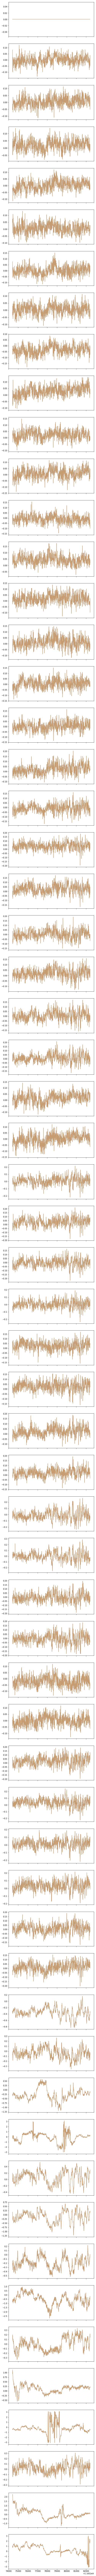

In [59]:
def plot_solutions(times, phase, ystar, error, antenna_labels):
    fig,axs = plt.subplots(nrows=len(antenna_labels),sharex=True,figsize=(8,4*len(antenna_labels)))
    for i in range(len(antenna_labels)):
        axs[i].plot(times,phase[:,:,0,0])
        axs[i].plot(times,ystar[:,:,0,0])
        axs[i].fill_between(times, ystar[:,:,0,0] + error[:,:,0,0], ystar[:,:,0,0] - error[:,:,0,0], alpha=0.25)
    